# Imaging and deconvolution demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

results_dir = '/tmp/'

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u

from matplotlib import pyplot as plt


from rascil.data_models import PolarisationFrame

from rascil.processing_components import create_blockvisibility, show_image, export_image_to_fits, \
    deconvolve_cube, restore_cube, create_named_configuration, create_test_image, \
    create_image_from_visibility, advise_wide_field, invert_2d, predict_2d, \
    plot_uvcoverage, plot_visibility

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 

In [2]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

Construct LOW core configuration

In [3]:
lowr3 = create_named_configuration('LOWBD2', rmax=750.0)
print(lowr3)

create_named_configuration: LOWBD2
	(<Quantity -2565018.31203579 m>, <Quantity 5085711.90373391 m>, <Quantity -2861033.10788063 m>)
	GeodeticLocation(lon=<Longitude 116.76444824 deg>, lat=<Latitude -26.82472208 deg>, height=<Quantity 300. m>)
create_configuration_from_file: Maximum radius 750.0 m includes 236 antennas/stations
Configuration:

Name: LOWBD2
	Number of antennas/stations: 236
	Names: <xarray.DataArray 'names' (id: 236)>
array(['LOWBD2_0', 'LOWBD2_1', 'LOWBD2_2', 'LOWBD2_3', 'LOWBD2_4',
       'LOWBD2_5', 'LOWBD2_6', 'LOWBD2_7', 'LOWBD2_8', 'LOWBD2_9',
       'LOWBD2_10', 'LOWBD2_11', 'LOWBD2_12', 'LOWBD2_13', 'LOWBD2_14',
       'LOWBD2_15', 'LOWBD2_16', 'LOWBD2_17', 'LOWBD2_18', 'LOWBD2_19',
       'LOWBD2_20', 'LOWBD2_21', 'LOWBD2_22', 'LOWBD2_23', 'LOWBD2_24',
       'LOWBD2_25', 'LOWBD2_26', 'LOWBD2_27', 'LOWBD2_28', 'LOWBD2_29',
       'LOWBD2_30', 'LOWBD2_31', 'LOWBD2_32', 'LOWBD2_33', 'LOWBD2_34',
       'LOWBD2_35', 'LOWBD2_36', 'LOWBD2_37', 'LOWBD2_38', 'LOWBD2_39

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [4]:
times = numpy.zeros([1])
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_blockvisibility(lowr3, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))
print(vt)

create_blockvisibility: created 1 times
create_blockvisibility: 27966 rows, 0.003 GB
BlockVisibility:
	Source unknown
	Phasecentre: <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>
	Polarisation Frame: stokesI
	Configuration: LOWBD2
	Metadata: None
	xarray.Dataset: <xarray.Dataset>
Dimensions:            (baseline: 27966, frequency: 1, polarisation: 1, time: 1, uvw_index: 3)
Coordinates:
  * time               (time) float64 5.085e+09
  * baseline           (baseline) MultiIndex
  - antenna1           (baseline) int64 0 0 0 0 0 0 ... 233 233 233 234 234 235
  - antenna2           (baseline) int64 0 1 2 3 4 5 ... 233 234 235 234 235 235
  * frequency          (frequency) float64 1e+08
  * polarisation       (polarisation) <U1 'I'
  * uvw_index          (uvw_index) <U1 'u' 'v' 'w'
Data variables:
    integration_time   (time) float64 1.0
    datetime           (time) datetime64[ns] 2020-01-01T10:31:38.475882830
    vis                (time, baseline, frequency, polarisation) complex12

In [5]:
advice = advise_wide_field(vt, guard_band_image=3.0, delA=0.1, facets=1, wprojection_planes=1, 
                           oversampling_synthesised_beam=4.0)
cellsize = advice['cellsize']

advise_wide_field: (max_wavelength) Maximum wavelength 2.998 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 2.998 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 383.3 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 125.8 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 35.0 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 0.0857 (rad) 4.91 (deg) 1.77e+04 (asec)
advise_wide_field: (image_fov) Image field of view 0.257 (rad) 14.7 (deg) 5.3e+04 (asec)
advise_wide_field: (synthesized_beam) Synthesized beam 0.00261 (rad) 0.149 (deg) 538 (asec)
advise_wide_field: (cellsize) Cellsize 0.000652 (rad) 0.0374 (deg) 135 (asec)
advice_wide_field: (npixels) Npixels per side = 394
advice_wide_field: (npixels2) Npixels (power of 2) per side = 512
advice_wide_field: (npixels23) Npixels (power of 2, 3) per side = 512
advice_wide_field: (npixels_min) Npixels (power of 2, 3, 4, 5) per side = 512
advice_wide_field: (w_sampling_image) W sa

Plot the synthesized uv coverage.

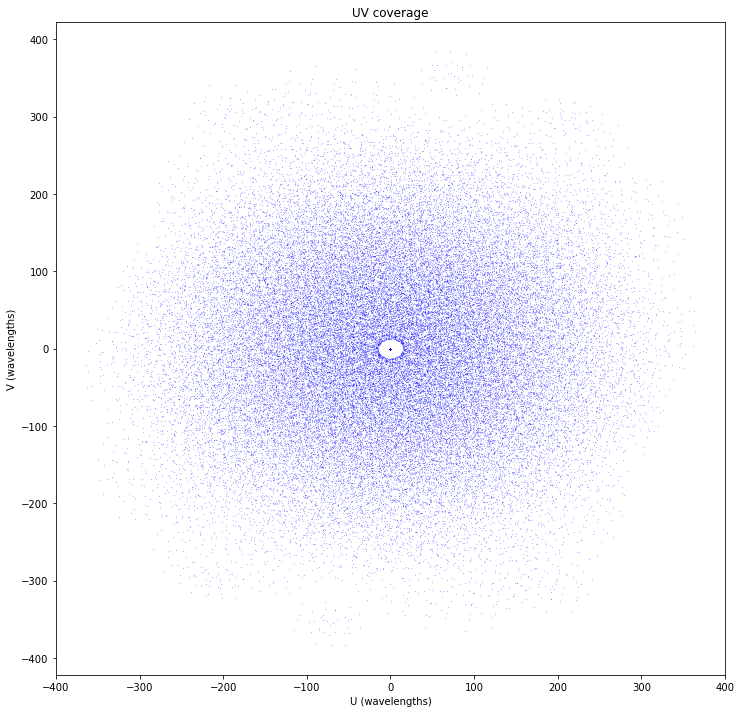

In [6]:
plt.clf()
plot_uvcoverage([vt])
plt.show()

Read the venerable test image, constructing an image

import_image_from_fits: created >f4 image of shape (256, 256)
import_image_from_fits: Max, min in /Users/timcornwell/Code/rascil/data/models/M31.MOD = 1.006458, 0.000000
replicate_image: replicating shape (1, 1, 256, 256) to (1, 1, 256, 256)


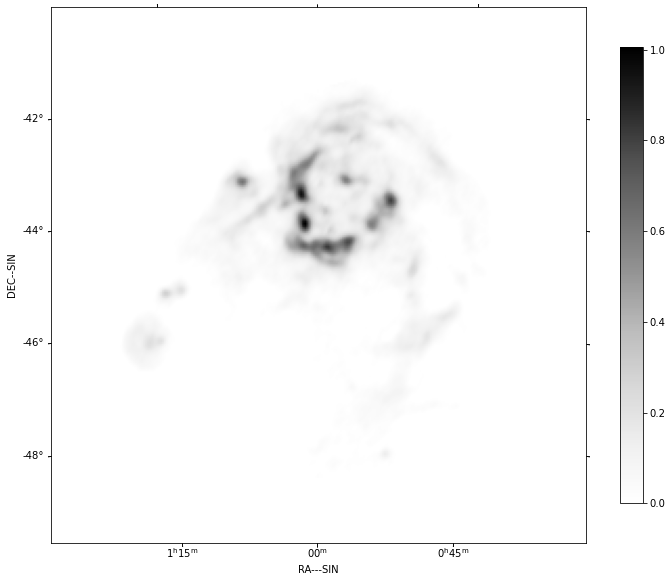

In [7]:
m31image = create_test_image(frequency=frequency, cellsize=cellsize)
nchan, npol, ny, nx = m31image["pixels"].data.shape
m31image.wcs.wcs.crval[0] = vt.phasecentre.ra.deg
m31image.wcs.wcs.crval[1] = vt.phasecentre.dec.deg
m31image.wcs.wcs.crpix[0] = float(nx // 2)
m31image.wcs.wcs.crpix[1] = float(ny // 2)

fig=show_image(m31image)

create_griddata_from_array: created complex128 image of shape (1, 1, 1, 256, 256)
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    (14.94718025, -44.96261426)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>


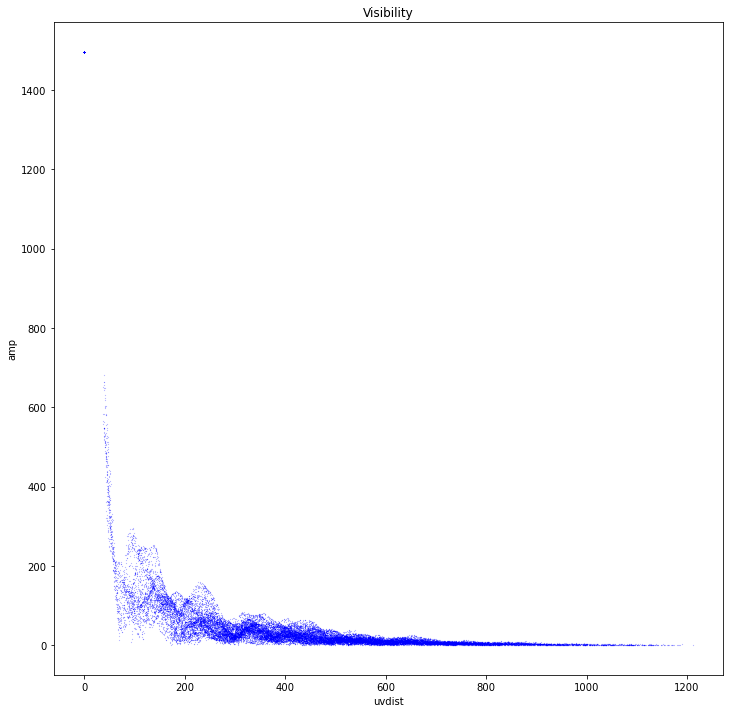

In [8]:
vt = predict_2d(vt, m31image, context='2d')

plt.clf()
plot_visibility([vt])
plt.show()

Make the dirty image and point spread function

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 363.929962 wavelengths
create_image_from_visibility: Critical cellsize = 0.001374 radians, 0.078718 degrees
create_image_from_visibility: Cellsize          = 0.000652292 radians, 0.0373736 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
create_griddata_from_array: created complex128 image of shape (1, 1, 1, 512, 512)
create_griddata_from_array: created complex128 image of shape (1, 1, 1, 512, 512)
Max, min in dirty image = 14.077953, -3.433541, sumwt = 27730.000000
Max, min in PSF         = 1.000000, -0.011578, sumwt = 27730.000000


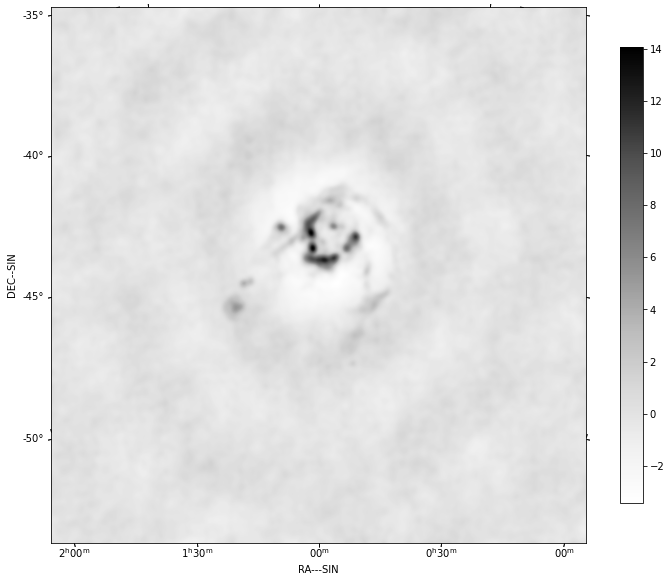

In [9]:
model = create_image_from_visibility(vt, cellsize=cellsize, npixel=512)
dirty, sumwt = invert_2d(vt, model, context='2d')
psf, sumwt = invert_2d(vt, model, context='2d', dopsf=True)

show_image(dirty)
print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty["pixels"].data.max(), dirty["pixels"].data.min(), sumwt))

print("Max, min in PSF         = %.6f, %.6f, sumwt = %f" % (psf["pixels"].data.max(), psf["pixels"].data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging_dirty.fits'%(results_dir))
export_image_to_fits(psf, '%s/imaging_psf.fits'%(results_dir))

Deconvolve using clean

deconvolve_cube : window is inner quarter
deconvolve_cube : Cleaning inner quarter of each sky plane
deconvolve_cube : PSF support = +/- 256 pixels
deconvolve_cube : PSF shape (1, 1, 512, 512)
deconvolve_cube : Multi-scale clean of each polarisation and channel separately
deconvolve_cube : Processing pol 0, channel 0
msclean : Peak of PSF = 1.0 at (256, 256)
msclean : Peak of Dirty = 14.077953 Jy/beam at (296, 248) 
msclean : Coupling matrix =
 [[1.         0.9714781  0.65793983 0.16096374]
 [0.9714781  0.94438569 0.64486697 0.16018117]
 [0.65793983 0.64486697 0.48835184 0.14900174]
 [0.16096374 0.16018117 0.14900174 0.09037368]]
msclean : Max abs in dirty Image = 14.077953 Jy/beam
msclean : Start of minor cycle
msclean : This minor cycle will stop at 10000 iterations or peak < 0.014078 (Jy/beam)
msclean : Timing for setup: 0.453 (s) for dirty shape (512, 512), PSF shape (512, 512) , scales [0, 3, 10, 30]
msclean : Minor cycle 0, peak [12.13528403 12.06771482 11.19154252  7.85483902] a

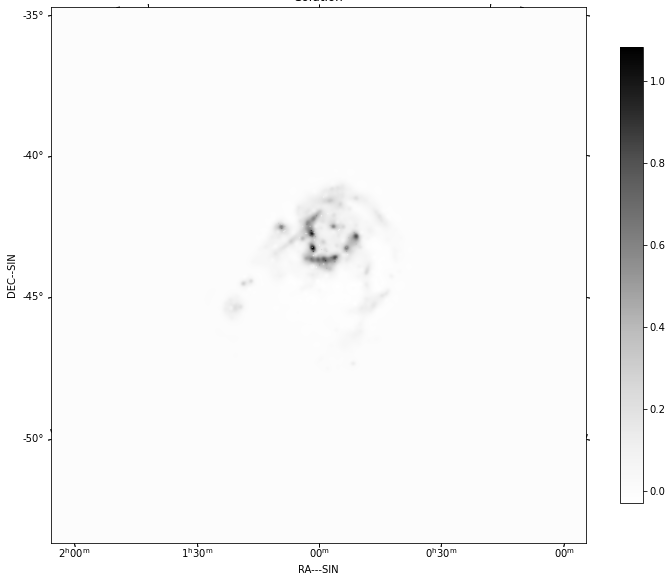

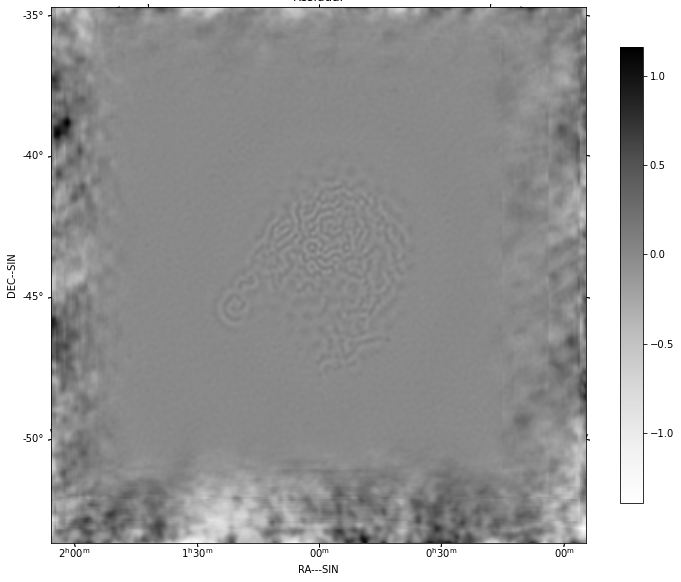

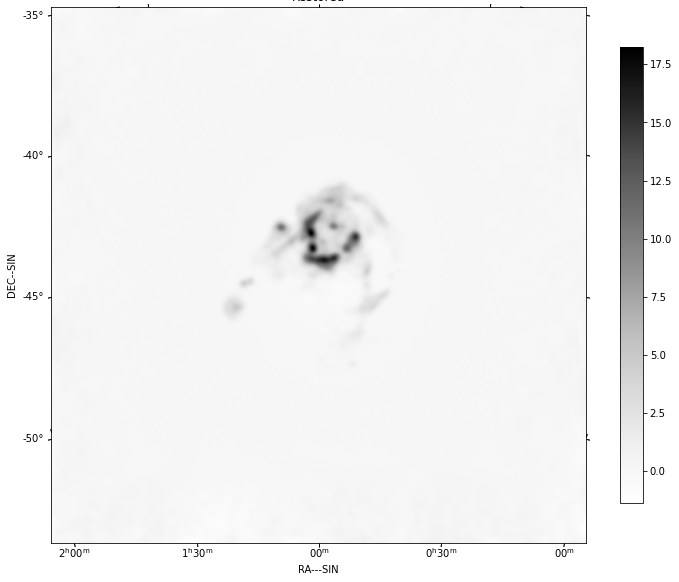

In [10]:
comp, residual = deconvolve_cube(dirty, psf, niter=10000, threshold=0.001, fractional_threshold=0.001,
                                 window_shape='quarter', gain=0.7, scales=[0, 3, 10, 30])

restored = restore_cube(comp, psf, residual)

# Show the results

fig=show_image(comp)
plt.title('Solution')
fig=show_image(residual)
plt.title('Residual')
fig=show_image(restored)
plt.title('Restored')

print(restored)

Predict the visibility of the model

In [11]:
vtmodel = create_blockvisibility(lowr3, times, frequency, channel_bandwidth=channel_bandwidth,
                            weight=1.0, phasecentre=phasecentre, 
                            polarisation_frame=PolarisationFrame('stokesI'))
vtmodel=predict_2d(vtmodel, comp, context='2d')

create_blockvisibility: created 1 times
create_blockvisibility: 27966 rows, 0.003 GB
create_griddata_from_array: created complex128 image of shape (1, 1, 1, 512, 512)


Now we will plot the original visibility and the residual visibility.

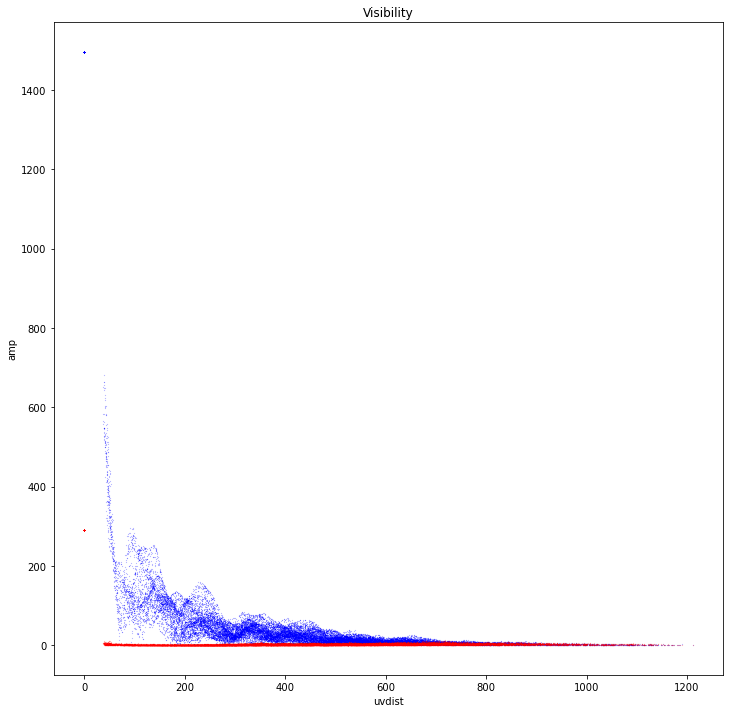

In [12]:
vtmodel.vis.values = vt.vis.values - vtmodel.vis.values

plt.clf()
plot_visibility([vt, vtmodel], colors=['b', 'r'])
plt.show()